In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim

if os.getcwd() != "/content/drive/MyDrive/q1/notebooks":
    os.chdir(os.path.join("drive", "MyDrive", "q1", "notebooks"))

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
TRAIN_PATH = "../data/train.csv"
TEST_PATH = "../data/test.csv"
SUBMISSION_PATH = "../data/gender_submission.csv"

TRAIN_PROCESSED_PATH = "../data/train_transformed.csv"
TEST_PROCESSED_PATH = "../data/test_transformed.csv"

CATEGORICAL = ["Sex", "Pclass", "Cabin", "Embarked"]
NUMERICAL = ["Age", "Fare", "SibSp", "Parch"]

LABEL = "Survived"
COLS_TO_TRAIN = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
COLS_TO_TRAIN_CAT = CATEGORICAL.copy()
COLS_TO_TRAIN_CAT.remove("Cabin")
COLS_TO_TRAIN_NUM = NUMERICAL

os.getcwd()

'/content/drive/My Drive/q1/notebooks'

# Pre processamento

In [24]:
train = pd.read_csv(TRAIN_PATH, index_col=0)
test = pd.read_csv(TEST_PATH)

In [25]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## EDA

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [27]:
train.describe()[NUMERICAL]

,Age,Fare,SibSp,Parch
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,0.523008,0.381594
std,14.526497,49.693429,1.102743,0.806057
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,7.910400,0.000000,0.000000
50%,28.000000,14.454200,0.000000,0.000000
75%,38.000000,31.000000,1.000000,0.000000
max,80.000000,512.329200,8.000000,6.000000


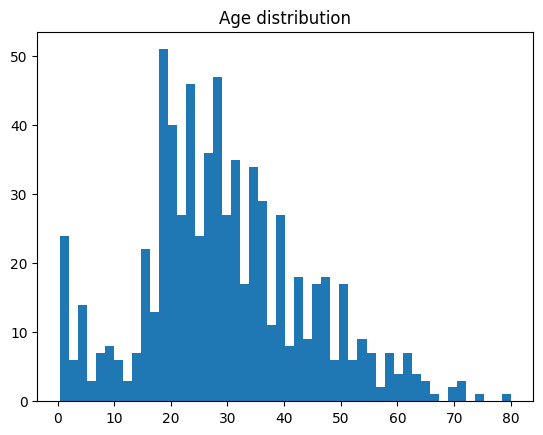

In [28]:
plt.hist(train["Age"], bins=50)
plt.title("Age distribution")
plt.show()

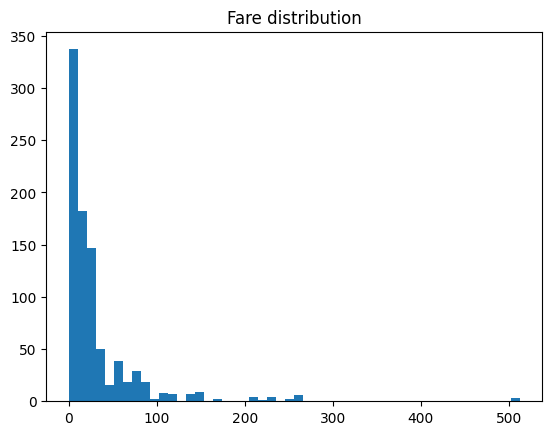

In [29]:
plt.hist(train["Fare"], bins=50)
plt.title("Fare distribution")
plt.show()

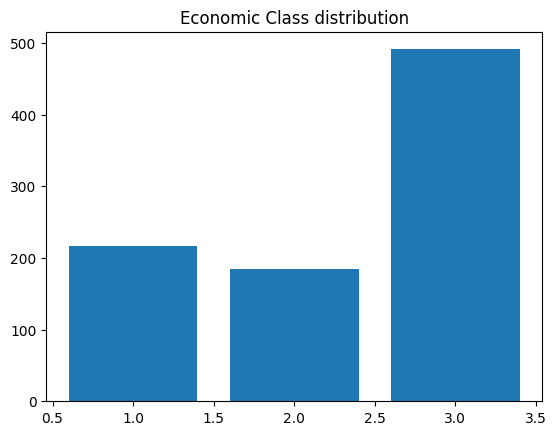

In [30]:
plt.bar(train["Pclass"].value_counts().index, train["Pclass"].value_counts().values)
plt.title("Economic Class distribution")
plt.show()

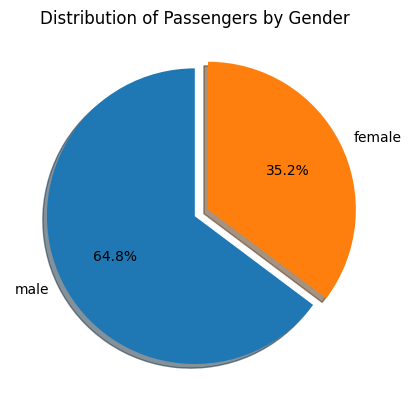

In [31]:
plt.pie(train["Sex"].value_counts(), labels=["male", "female"], autopct='%1.1f%%', explode=(0, 0.1), startangle=90, shadow=True)
plt.title("Distribution of Passengers by Gender")
plt.show()

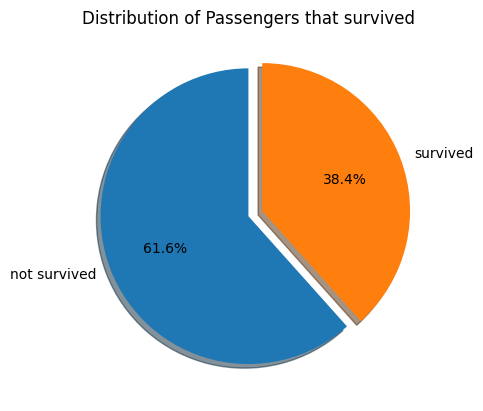

In [32]:
plt.pie(train[LABEL].value_counts(), labels=["not survived", "survived"], autopct='%1.1f%%', explode=(0, 0.1), startangle=90, shadow=True)
plt.title("Distribution of Passengers that survived")
plt.show()

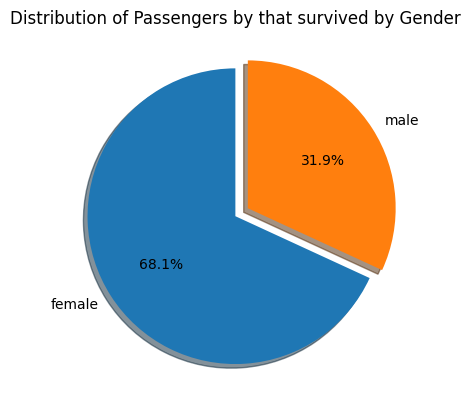

In [33]:
data_to_plot = train.loc[train[LABEL] == 1, "Sex"].value_counts()

plt.pie(data_to_plot, labels=data_to_plot.index, autopct='%1.1f%%', explode=(0, 0.1), startangle=90, shadow=True)
plt.title("Distribution of Passengers by that survived by Gender")
plt.show()

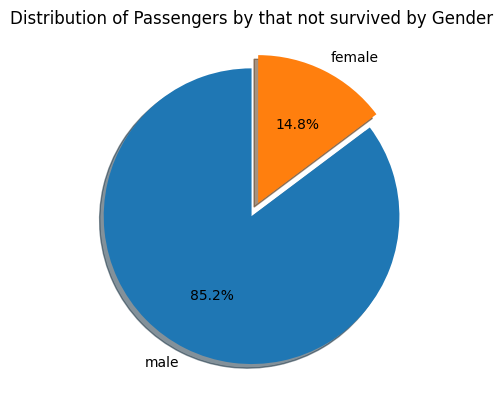

In [34]:
data_to_plot = train.loc[train[LABEL] == 0, "Sex"].value_counts()

plt.pie(data_to_plot, labels=data_to_plot.index, autopct='%1.1f%%', explode=(0, 0.1), startangle=90, shadow=True)
plt.title("Distribution of Passengers by that not survived by Gender")
plt.show()

In [44]:
data_to_plot = train.groupby("Pclass").mean()[LABEL]

<ipython-input-44-9efe0b9d5f51>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_to_plot = train.groupby("Pclass").mean()[LABEL]


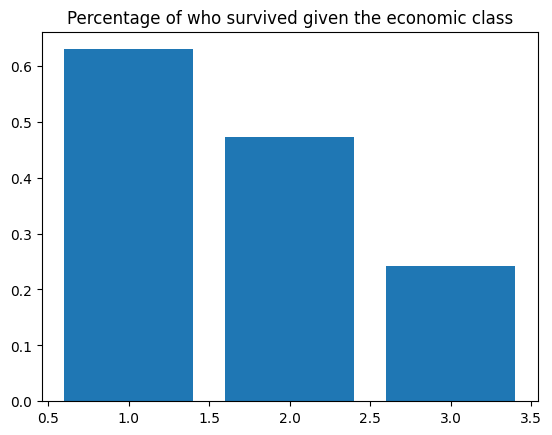

In [47]:
plt.bar(data_to_plot.index, data_to_plot.values)
plt.title("Percentage of who survived given the economic class")
plt.show()

In [65]:
data_to_plot = train.groupby(["Pclass", "Sex"]).mean()[LABEL].sort_values()

<ipython-input-65-2d6e7ac5ba8f>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_to_plot = train.groupby(["Pclass", "Sex"]).mean()[LABEL].sort_values()


In [66]:
data_to_plot

Pclass  Sex   
3       male      0.135447
2       male      0.157407
1       male      0.368852
3       female    0.500000
2       female    0.921053
1       female    0.968085
Name: Survived, dtype: float64

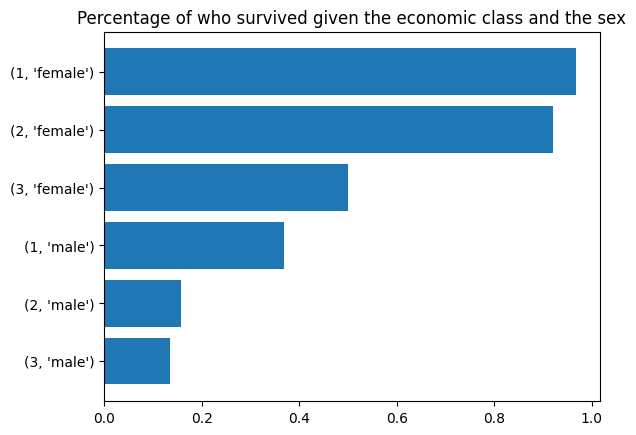

In [67]:
plt.barh(
    list(map(str, data_to_plot.index.to_list())),
    data_to_plot.values,
)
plt.title("Percentage of who survived given the economic class and the sex")
plt.show()

## Feature engineering

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, COLS_TO_TRAIN_NUM),
        ('cat', categorical_transformer, COLS_TO_TRAIN_CAT)
    ])


pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


In [ ]:
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [ ]:
X_train = train[COLS_TO_TRAIN]
y_train = train[LABEL]

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'SibSp',
                                                   'Parch']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Pclass',
                                                   'Embarked'])]))])

In [ ]:
X_transformed = pipeline.transform(X_train)

In [ ]:
X_transformed.shape

(891, 12)

In [ ]:
transformed_feature_names = pipeline.named_steps['preprocessor']\
    .named_transformers_['cat']\
    .named_steps['onehot']\
    .get_feature_names_out(COLS_TO_TRAIN_CAT)

transformed_feature_names = list(transformed_feature_names) + COLS_TO_TRAIN_NUM

In [ ]:
transformed_df = pd.DataFrame(X_transformed, columns=transformed_feature_names).assign(Label = y_train.values)

In [ ]:
transformed_df

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Age,Fare,SibSp,Parch,Label
0,-0.592481,-0.502445,0.432793,-0.473674,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
1,0.638789,0.786845,0.432793,-0.473674,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
2,-0.284663,-0.488854,-0.474545,-0.473674,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
3,0.407926,0.420730,0.432793,-0.473674,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
4,0.407926,-0.486337,-0.474545,-0.473674,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.207709,-0.386671,-0.474545,-0.473674,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0
887,-0.823344,-0.044381,-0.474545,-0.473674,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
888,0.000000,-0.176263,0.432793,2.008933,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
889,-0.284663,-0.044381,-0.474545,-0.473674,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1


In [ ]:
transformed_df.corr()["Label"].sort_values(ascending=False)

Label         1.000000
Pclass_3      0.543351
Embarked_Q    0.285904
Sex_male      0.257307
Fare          0.168240
Embarked_S    0.093349
Pclass_2      0.081629
SibSp         0.003650
Pclass_1     -0.035322
Sex_female   -0.069809
Parch        -0.149683
Age          -0.322308
Embarked_C   -0.543351
Name: Label, dtype: float64

In [ ]:
# transformed_df.to_csv("../data/train_transformed.csv", index=False)

In [ ]:
X_test = test[COLS_TO_TRAIN]

X_test_transformed = pipeline.transform(X_test)

In [ ]:
test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_feature_names)

In [ ]:
#test_transformed_df.to_csv("../data/test_transformed.csv", index=False)

# Treinamento

In [80]:
train_data = pd.read_csv(TRAIN_PROCESSED_PATH)
test_data = pd.read_csv(TEST_PROCESSED_PATH)
test_submission = pd.read_csv(SUBMISSION_PATH)

In [81]:
test_data = test_data.assign(
    Label = test_submission["Survived"].values
)

In [82]:
X_train = train_data.drop(columns=["Label"]).values
X_test = test_data.drop(columns=["Label"]).values
y_train = train_data["Label"].values
y_test = test_data["Label"].values

In [83]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [84]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)

X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [85]:
X_train.shape, X_test.shape, X_val.shape

(torch.Size([801, 12]), torch.Size([418, 12]), torch.Size([90, 12]))

In [86]:
class TitanicNN(nn.Module):
    def __init__(self):
        super(TitanicNN, self).__init__()
        self.fc1 = nn.Linear(in_features=X_train.shape[1], out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=1)
        self.dropout = nn.Dropout(0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


In [87]:
# Create the model
model = TitanicNN()

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# Training loop
num_epochs = 200
batch_size = 64

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val.view(-1, 1))
        val_losses.append(val_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

Epoch [1/200], Train Loss: 0.6733, Val Loss: 0.6751
Epoch [2/200], Train Loss: 0.6544, Val Loss: 0.6706
Epoch [3/200], Train Loss: 0.6507, Val Loss: 0.6662
Epoch [4/200], Train Loss: 0.6449, Val Loss: 0.6619
Epoch [5/200], Train Loss: 0.6391, Val Loss: 0.6575
Epoch [6/200], Train Loss: 0.6347, Val Loss: 0.6531
Epoch [7/200], Train Loss: 0.6305, Val Loss: 0.6487
Epoch [8/200], Train Loss: 0.6157, Val Loss: 0.6443
Epoch [9/200], Train Loss: 0.6046, Val Loss: 0.6398
Epoch [10/200], Train Loss: 0.6085, Val Loss: 0.6353
Epoch [11/200], Train Loss: 0.6012, Val Loss: 0.6306
Epoch [12/200], Train Loss: 0.5869, Val Loss: 0.6258
Epoch [13/200], Train Loss: 0.5821, Val Loss: 0.6208
Epoch [14/200], Train Loss: 0.5692, Val Loss: 0.6157
Epoch [15/200], Train Loss: 0.5710, Val Loss: 0.6106
Epoch [16/200], Train Loss: 0.5611, Val Loss: 0.6054
Epoch [17/200], Train Loss: 0.5515, Val Loss: 0.6001
Epoch [18/200], Train Loss: 0.5428, Val Loss: 0.5947
Epoch [19/200], Train Loss: 0.5355, Val Loss: 0.5893
Ep

In [88]:
# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    y_pred = model(X_test)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions

accuracy = (y_pred == y_test.view(-1, 1)).float().mean()
print(f'Test Accuracy: {accuracy.item() * 100:.2f}%')

Test Accuracy: 93.30%


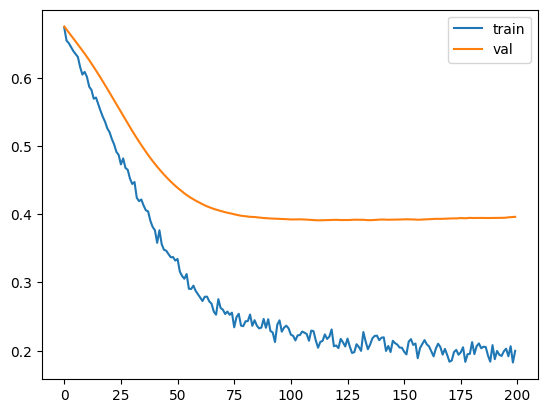

In [91]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.show()

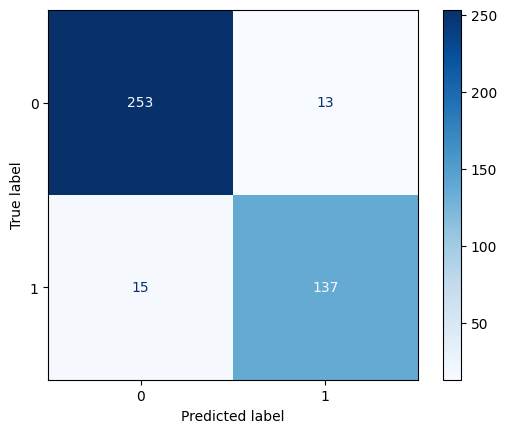

In [95]:
# Compute the confusion matrix
cm = confusion_matrix(y_test.numpy(), y_pred.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='.4g');

# Treinamento menos features

In [96]:
selected_cols = [
    "Sex_female",
    "Sex_male",
    "Pclass_1",
    "Pclass_2",
    "Pclass_3",
    "Label"
]

train_data_less_dim = train_data[selected_cols]
test_data_less_dim = test_data[selected_cols]

In [97]:
X_train = train_data_less_dim.drop(columns=["Label"]).values
X_test = test_data_less_dim.drop(columns=["Label"]).values
y_train = train_data_less_dim["Label"].values
y_test = test_data_less_dim["Label"].values

In [98]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [99]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)

X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [100]:
# Create the model
model = TitanicNN()

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# Training loop
num_epochs = 200
batch_size = 64

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val.view(-1, 1))
        val_losses.append(val_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

Epoch [1/200], Train Loss: 0.6604, Val Loss: 0.6810
Epoch [2/200], Train Loss: 0.6624, Val Loss: 0.6772
Epoch [3/200], Train Loss: 0.6508, Val Loss: 0.6734
Epoch [4/200], Train Loss: 0.6416, Val Loss: 0.6696
Epoch [5/200], Train Loss: 0.6405, Val Loss: 0.6659
Epoch [6/200], Train Loss: 0.6348, Val Loss: 0.6621
Epoch [7/200], Train Loss: 0.6264, Val Loss: 0.6584
Epoch [8/200], Train Loss: 0.6168, Val Loss: 0.6546
Epoch [9/200], Train Loss: 0.6145, Val Loss: 0.6507
Epoch [10/200], Train Loss: 0.6049, Val Loss: 0.6469
Epoch [11/200], Train Loss: 0.6007, Val Loss: 0.6429
Epoch [12/200], Train Loss: 0.6010, Val Loss: 0.6388
Epoch [13/200], Train Loss: 0.5895, Val Loss: 0.6346
Epoch [14/200], Train Loss: 0.5890, Val Loss: 0.6304
Epoch [15/200], Train Loss: 0.5764, Val Loss: 0.6261
Epoch [16/200], Train Loss: 0.5759, Val Loss: 0.6218
Epoch [17/200], Train Loss: 0.5664, Val Loss: 0.6174
Epoch [18/200], Train Loss: 0.5517, Val Loss: 0.6129
Epoch [19/200], Train Loss: 0.5453, Val Loss: 0.6083
Ep

In [101]:
# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    y_pred = model(X_test)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions

accuracy = (y_pred == y_test.view(-1, 1)).float().mean()
print(f'Test Accuracy: {accuracy.item() * 100:.2f}%')

Test Accuracy: 94.02%


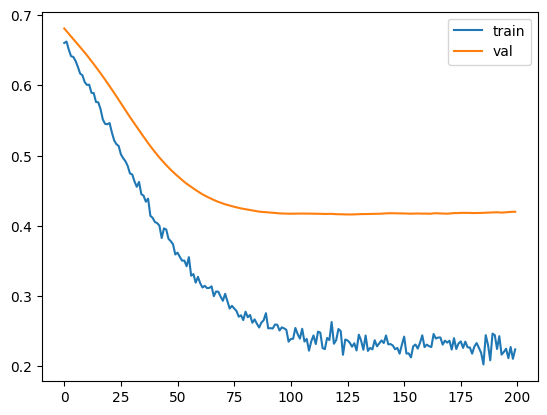

In [102]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.show()

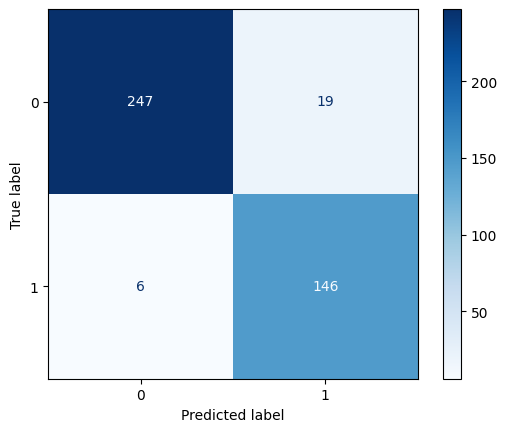

In [103]:
# Compute the confusion matrix
cm = confusion_matrix(y_test.numpy(), y_pred.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='.4g');